# Weight Initialization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from pathlib import Path
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
def build_dataset(root, batch_size, download=False):
    train_dataset = datasets.MNIST(
        root=root,                                
        train=True,
        transform=transforms.ToTensor(),
        download=download)
    test_dataset = datasets.MNIST(
        root=root, 
        train=False,
        transform=transforms.ToTensor(),
        download=download)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size, 
        shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size, 
        shuffle=True)
    return train_dataset, test_dataset, train_loader, test_loader

train_dataset, test_dataset, train_loader, test_loader = build_dataset(root="./data/mnist", batch_size=256, download=True)

## Hook Function

Not use it frequently, but it is useful to know how to get inside of values in the network.

In [3]:
class MNISTmodel(nn.Module):
    def __init__(self, w_std):
        super(MNISTmodel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 100),
            nn.Sigmoid(),
            nn.Linear(100, 100),
            nn.Sigmoid(),
            nn.Linear(100, 10)
        )
        self.handlers = []
        self._reset_his()
        self.init_weight(w_std)
        
    def _reset_his(self):
        self.his = defaultdict(list)
        
    def init_weight(self, w_std):
        assert isinstance(w_std, str), "string type"
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if w_std == "xavier":
                    torch.nn.init.xavier_normal_(layer.weight)
                else:
                    std = float(w_std)
                    torch.nn.init.normal_(layer.weight, mean=0, std=std)
    
    def _reset_handlers(self):
        for handle in self.handlers:
            handle.remove()
        self.handlers = []
    
    def register(self):
        # loop the `self.layers`
        for i, layer in enumerate(self.layers):
            # find the linear layer and 
            # isinstance function check if an object is a certain class
            if isinstance(layer, nn.Linear) and i != (len(self.layers)-1):
                handle1 = layer.register_forward_hook(self.f_hook_function)
                handle2 = layer.register_full_backward_hook(self.b_hook_function)
                self.handlers.append(handle1)
                self.handlers.append(handle2)    
                
    def f_hook_function(self, *x):
        m, i, o = x
        self.his["f"].append(o.data.cpu())  # (batch, activations)
        self.his["input"].append(i[0].data.cpu())
        
    def b_hook_function(self, *x):
        m, i, o = x
        self.his["b"].append(o[0].data.cpu())
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x
    
    def reformat_his(self):
        def reformat(typ):
            m1, m2 = [], []
            for i, tensor in enumerate(self.his[typ]):
                # forward: m1 = even, m2 = odd
                if typ=="f":
                    if i % 2 == 0:  
                        m1.append(tensor)
                    else:
                        m2.append(tensor)
                # backward: m1 = odd, m2 = even
                else:
                    if i % 2 == 0:  
                        m2.append(tensor)
                    else:
                        m1.append(tensor)                    
            return torch.cat(m1), torch.cat(m2)
        i_m1, i_m2 = reformat("input")
        f_m1, f_m2 = reformat("f")
        b_m1, b_m2 = reformat("b")
        his_dict = {"layer1": {"f": torch.sigmoid(f_m1).view(-1), "b": b_m1.view(-1), "input": i_m1.view(-1)}, 
                    "layer2": {"f": torch.sigmoid(f_m2).view(-1), "b": b_m2.view(-1), "input": i_m2.view(-1)}}
        self._reset_his()
        return his_dict

In [4]:
def train(model, train_loader, optimizer, loss_function, device):
    """train function"""
    model.train()
    train_loss = 0
    correct = 0
    
    for i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    train_acc = 100*(correct / len(train_loader.dataset))
    return train_loss, train_acc

def test(model, test_loader, loss_function, device):
    """test function"""
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_acc = 100*(correct / len(test_loader.dataset))

    return test_loss, test_acc

def main_train(model, train_loader, test_loader, n_step, sv_path, device):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    best_acc = 0.0
    plot_dict = {"train_acc": [], "test_acc": [], "train_loss": [], "test_loss": []}
    
    for i, step in enumerate(range(n_step)):
        model.register()
        train_loss, train_acc = train(model, train_loader, optimizer, loss_function, device)
        his_dict = model.reformat_his()
        torch.save(his_dict, sv_path / f"{step}-his.pt")
        
        model._reset_handlers()
        test_loss, test_acc = test(model, test_loader, loss_function, device)
        
        plot_dict["train_loss"].append(train_loss)
        plot_dict["test_loss"].append(test_loss)        
        plot_dict["train_acc"].append(train_acc)
        plot_dict["test_acc"].append(test_acc)
        if i % 1 == 0:
            print(f"[Step] {step+1}/{n_step}")
            print(f"[Train] Average loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
            print(f"[Test] Average loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
            if test_acc >= best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), sv_path / f"best_model.pt")
                print(f"[Alert] best model saved")
        print("----"*10)
    return best_acc, plot_dict

In [4]:
torch.cuda.manual_seed(777)
torch.manual_seed(777)

device = "cuda"
n_step = 10
w_stds = ["1", "0.01", "xavier"]
w_dics = []
for w_std in w_stds:
    sv_path = Path(f"./states/state-dicts-{w_std}")
    if not sv_path.exists():
        sv_path.mkdir(parents=True)
    print(f"std = {w_std}")
    model = MNISTmodel(w_std).to(device)
    best_acc, plot_dict = main_train(model, train_loader, test_loader, n_step, sv_path, device)
    w_dics.append(plot_dict)

std = 1
[Step] 1/10
[Train] Average loss: 1083.3305, Accuracy: 14.36%
[Test] Average loss: 145.6207, Accuracy: 18.51%
[Alert] best model saved
----------------------------------------
[Step] 2/10
[Train] Average loss: 760.9779, Accuracy: 23.04%
[Test] Average loss: 115.3278, Accuracy: 27.25%
[Alert] best model saved
----------------------------------------
[Step] 3/10
[Train] Average loss: 626.0574, Accuracy: 31.05%
[Test] Average loss: 97.6767, Accuracy: 34.66%
[Alert] best model saved
----------------------------------------
[Step] 4/10
[Train] Average loss: 538.5852, Accuracy: 37.57%
[Test] Average loss: 85.2580, Accuracy: 40.60%
[Alert] best model saved
----------------------------------------
[Step] 5/10
[Train] Average loss: 477.5791, Accuracy: 42.53%
[Test] Average loss: 76.5166, Accuracy: 45.11%
[Alert] best model saved
----------------------------------------
[Step] 6/10
[Train] Average loss: 432.2531, Accuracy: 46.39%
[Test] Average loss: 70.0442, Accuracy: 48.72%
[Alert] bes

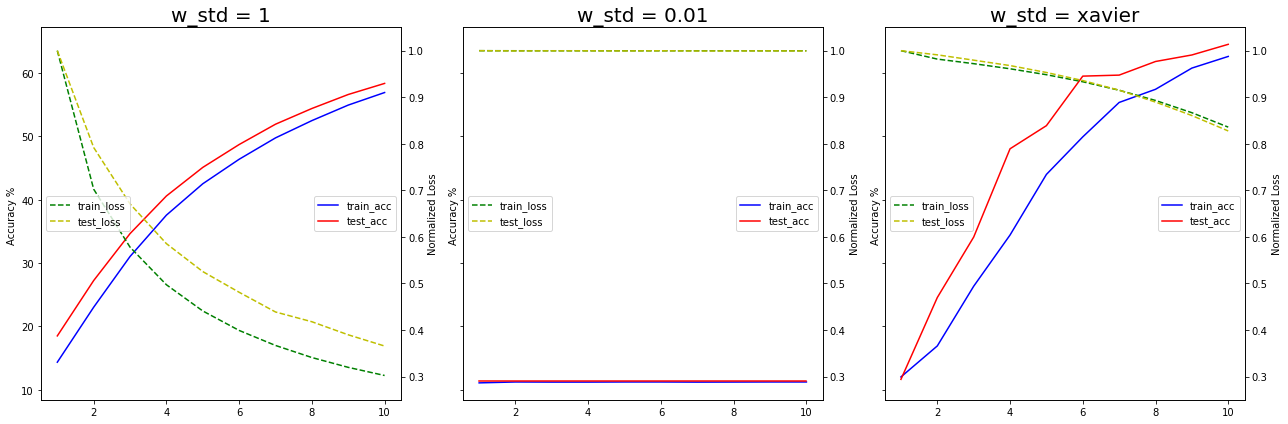

In [5]:
titles = ["w_std = 1", "w_std = 0.01", "w_std = xavier"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
xx = np.arange(1, 11)
join_axes = []
for i in range(3):
    ax = axes[i]
    ax.plot(xx, w_dics[i]["train_acc"], "b-", label="train_acc")
    ax.plot(xx, w_dics[i]["test_acc"], "r-", label="test_acc")
    ax.set_ylabel("Accuracy % ")
    ax.set_title(titles[i], fontsize=20)
    ax.legend(loc=5)
    
    ax2 = ax.twinx()
    train_l = np.array(w_dics[i]["train_loss"])
    test_l = np.array(w_dics[i]["test_loss"])
    ax2.plot(xx, train_l/train_l.max(), "g--", label="train_loss")
    ax2.plot(xx, test_l/test_l.max(), "y--", label="test_loss")
    ax2.set_ylabel("Normalized Loss")
    ax2.legend(loc=6)
    ax2.set_ylim(0.25, 1.05)
    if i > 0:
        sharey.get_shared_y_axes().join(sharey, ax2)
    else:
        sharey = ax2
    
plt.tight_layout()
plt.show()

In [4]:
import seaborn as sns

def draw(w_std, model_num, layer, ret_fig=False):
    from matplotlib.ticker import ScalarFormatter
    # load layer
    sv_path = Path(f"./states/state-dicts-{w_std}")
    load_path = lambda x: sv_path / f"{x}-his.pt"
    layer_dict = torch.load(load_path(model_num), map_location="cpu")
    
    title1 = f"Activation Values of Layer {layer}"
    title2 = f"Gradient Values of Layer {layer}"
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    ax1, ax2 = axes
    
    sns.histplot(layer_dict[f"layer{layer}"]["f"], bins=20, ax=ax1)
    
    ax1.set_xlabel("Activation values")
    ax1.set_ylabel("Counts")
    ax1.set_title(title1, fontsize=16, y=1.05)
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    
    sns.histplot(layer_dict[f"layer{layer}"]["b"], bins=20, ax=ax2)
    ax2.set_xlabel("Gradient values")
    ax2.set_ylabel("Counts")
    ax2.set_title(title2, fontsize=16, y=1.05)
    ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    fig.suptitle(f"w_std: {w_std} layer: {layer}", fontsize=20)
    plt.tight_layout()
    if ret_fig:
        plt.close()
        return fig
    else:
        plt.show()

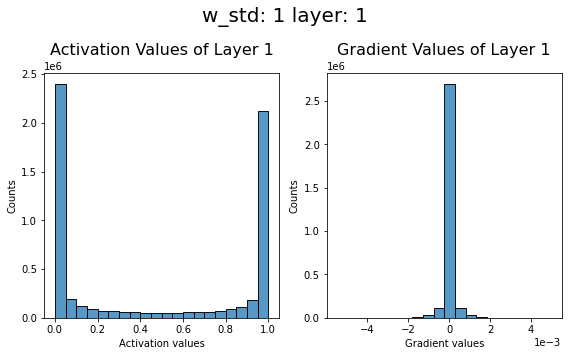

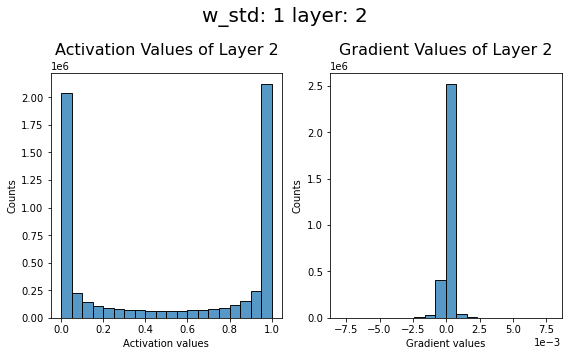

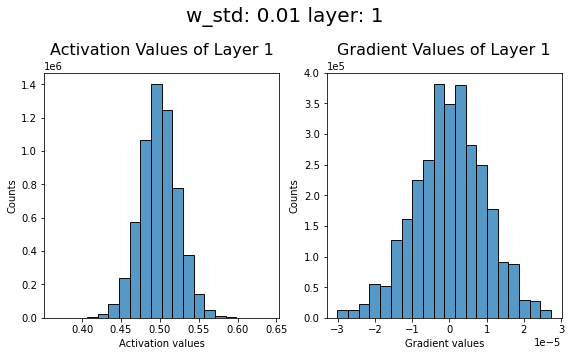

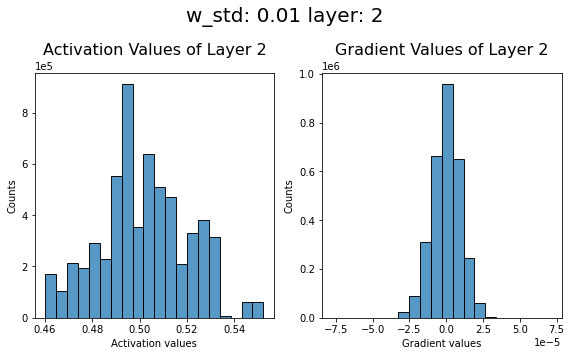

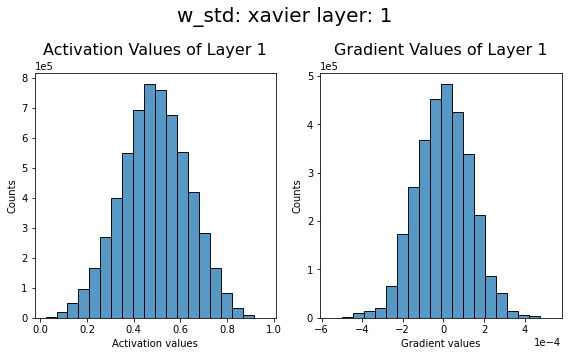

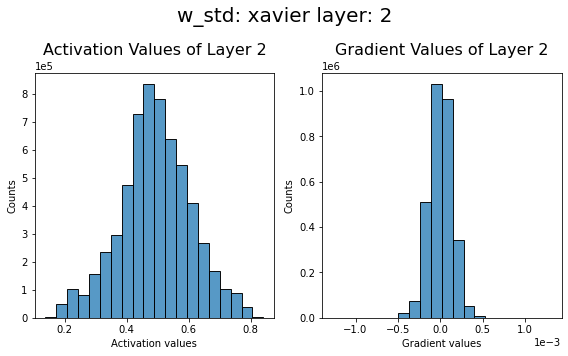

In [5]:
model_num = 9
w_stds = ["1", "0.01", "xavier"]

for w_std in w_stds:
    for layer in range(1, 3):
        draw(w_std, model_num, layer)    

---

# Overfitting

In [5]:
seed = 99
np.random.seed(seed)
n_half = 50//2
x1 = np.random.normal(0.8, 0.35, size=(n_half, 2))
x2 = np.random.normal(0.1, 0.5, size=(n_half, 2))
X = np.concatenate([x1, x2])

np.savetxt("./data/overfit_sample_data.csv", X, delimiter=",")

### Example Problem

Classify 50 data points(2 dimension) with 2 classes(0, 1)

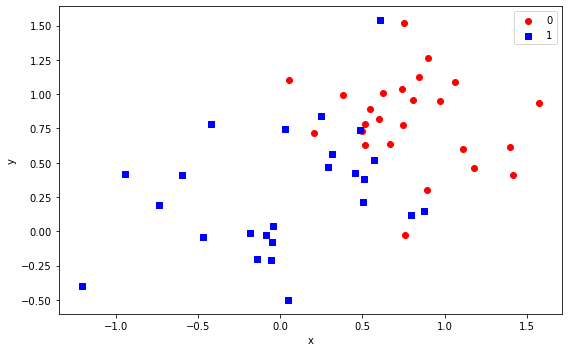

In [6]:
X = np.loadtxt("./data/overfit_sample_data.csv", delimiter=",")
n_half = len(X)//2
a = X[:n_half, :]
b = X[n_half:, :]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(a[:, 0], a[:, 1], marker="o", color="r", label="0")
ax.scatter(b[:, 0], b[:, 1], marker="s", color="b", label="1")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.tight_layout()
plt.show()

### Network and Loss function

In [7]:
datas = torch.FloatTensor(X)
targets = torch.FloatTensor([0]*len(a) + [1]*len(b)).unsqueeze(1)
print(f"data size = {datas.size()}")
print(f"target size = {targets.size()}")

data size = torch.Size([50, 2])
target size = torch.Size([50, 1])


In [8]:
class Network(nn.Module):
    def __init__(self, hidden_size):
        super(Network, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # Add sigmoid in last layer for binary cross entropy loss
        )
    
    def forward(self, x):
        o = self.layers(x)
        return o

In [9]:
def train(model, datas, targets, loss_function, optimizer):
    """if loss value is smaller than loss_criteria will stop the training"""
    model.train()
    loss_criteria = 0.1
    n_step = 20000
    for step in range(n_step):
        
        # 1) need to initialize for every trackable tensors
        optimizer.zero_grad()

        # 2) forward propagation
        outputs = model(datas)

        # 3) calculate Loss
        loss = loss_function(outputs, targets)

        # 4) back propagation
        loss.backward()

        # 5) update parameters
        optimizer.step()
        
        if loss.item() <= loss_criteria:
            break
    print(f" trained {step+1}, best loss : {loss.item():.4f}")
    
    return model

def draw_decision(model, datas, targets):
    """draw the dicision boundary"""
    X = datas.numpy()
    Y = targets.view(-1).numpy()
    markers = ("o", "s")
    colors = ("red", "blue")
    cmap = ListedColormap(colors)
    
    lim = 0.5
    x1_min, x1_max = X[:, 0].min() - lim, X[:, 0].max() + lim
    x2_min, x2_max = X[:, 1].min() - lim, X[:, 1].max() + lim
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    
    xx = torch.cat([torch.FloatTensor(xx1).view(-1, 1), 
                    torch.FloatTensor(xx2).view(-1, 1)], dim=1)
    model.eval()
    outputs = model(xx).ge(0.5).float().detach().numpy()
    Z = outputs.reshape(xx1.shape)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    for idx, (cl, color) in enumerate(zip([0, 1], colors)):
        ax.scatter(
            x=X[Y == cl, 0], 
            y=X[Y == cl, 1],
            alpha=0.6, 
            c=color,
            edgecolor='black',
            marker=markers[idx], 
            label=cl
        )
    plt.legend()
    plt.show()

### Training and Visualization

### without regularization

Training with 50 hidden size and 2 layer Neural Network

In [10]:
torch.manual_seed(seed)
hidden_size = 50
learning_rate = 0.05

model = Network(hidden_size)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

 trained 14282, best loss : 0.0996


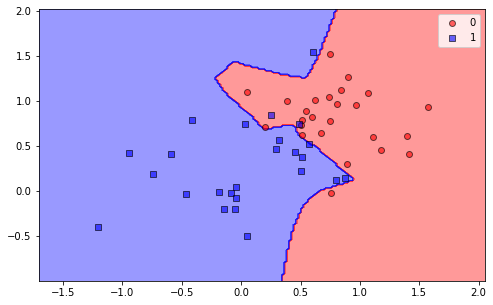

In [11]:
model = train(model, datas, targets, loss_function, optimizer)
draw_decision(model, datas, targets)

## Weight decay

In [12]:
torch.manual_seed(seed)
hidden_size = 50
learning_rate = 0.05
weight_decay_rate = 0.01  # 정규화 계수

model = Network(hidden_size)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate,
                      weight_decay=weight_decay_rate)

 trained 20000, best loss : 0.2566


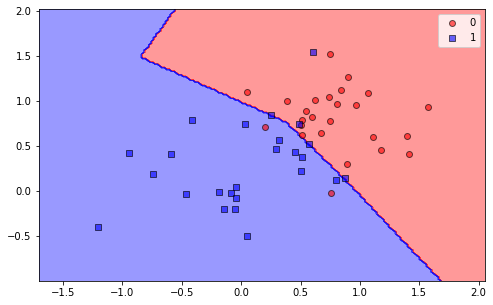

In [13]:
model = train(model, datas, targets, loss_function, optimizer)
draw_decision(model, datas, targets)

## Dropout

* [nn.Dropout](https://pytorch.org/docs/stable/nn.html#dropout)

In [14]:
class Network2(nn.Module):
    def __init__(self, hidden_size, drop_rate):
        super(Network2, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_rate),  # drop certain percentage of neurons
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_rate),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        o = self.layers(x)
        return o

In [15]:
torch.manual_seed(seed)
hidden_size = 50
learning_rate = 0.05
drop_rate=0.5

model = Network2(hidden_size, drop_rate)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate)

 trained 16677, best loss : 0.0986


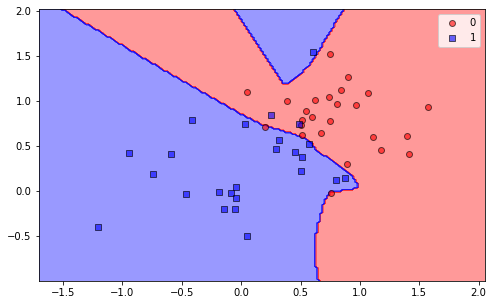

In [16]:
model = train(model, datas, targets, loss_function, optimizer)
draw_decision(model, datas, targets)

## Batch Normalization

* [nn.BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d)

In [17]:
class Network3(nn.Module):
    def __init__(self, hidden_size):
        super(Network3, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        o = self.layers(x)
        return o

In [18]:
torch.manual_seed(seed)
hidden_size = 50
learning_rate = 0.05

model = Network3(hidden_size)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate)

 trained 628, best loss : 0.0976


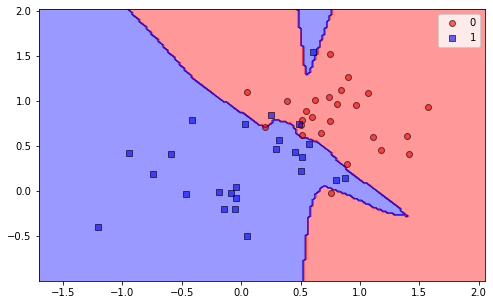

In [19]:
model = train(model, datas, targets, loss_function, optimizer)
draw_decision(model, datas, targets)

## Layer Normalization

* [nn.LayerNorm](https://pytorch.org/docs/stable/nn.html#layernorm)

In [20]:
class Network4(nn.Module):
    def __init__(self, hidden_size):
        super(Network4, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        o = self.layers(x)
        return o

In [21]:
torch.manual_seed(seed)
hidden_size = 50
learning_rate = 0.05

model = Network4(hidden_size)
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate)

 trained 2297, best loss : 0.0986


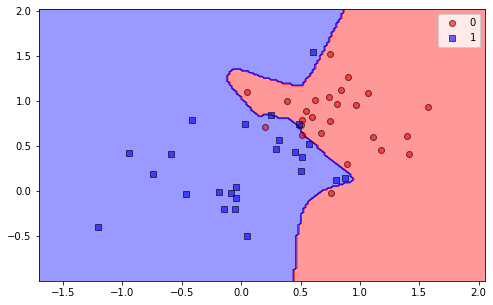

In [22]:
model = train(model, datas, targets, loss_function, optimizer)
draw_decision(model, datas, targets)